In [7]:
#import necessary liberaries
import pandas as pd                              #for data manipulation and analysis
import numpy as np                               #for numerical operations
import cv2 #openCvfor computer vision tasks
from PIL import Image
import PIL                                       #python imaging library for image processing 
import matplotlib.pyplot as plt                  #for creating plots and visualisations
import plotly.express as px                      #interactive plotting library
import seaborn as sns                            #statistical data visualization
import glob                                      #for searching files using patterns
import random                                    #for generating random numbers
import os                                        #for interacting with operating system
import keras.utils as image
%matplotlib inline
import tensorflow as tf
from os import listdir                               #for listing files in directory
from matplotlib.image import imread
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.model_selection  import train_test_split
from tensorflow.keras.models import load_model

from tensorflow.keras import layers

import time
from concurrent.futures import ThreadPoolExecutor
# Display some images
import matplotlib.image as mpimg


#set seed for reproducibility
random.seed(100)
np.random.seed(100)


In [4]:
dicom_data = pd.read_csv('input/csv/dicom_info.csv')
#image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [5]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


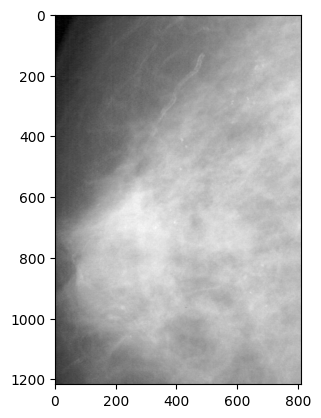

In [8]:
# Filter 'dicom_data' DataFrame to select rows where 'SeriesDescription' is 'cropped images'
cropped_images=dicom_data.loc[dicom_data["SeriesDescription"] == 'cropped images']["image_path"]

# Set the directory path for JPEG images
image_dir = 'input/jpeg'

cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in cropped_images[0:5]:
    cropped_images_show = Image.open(file)
    # Convert the image to grayscale
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')


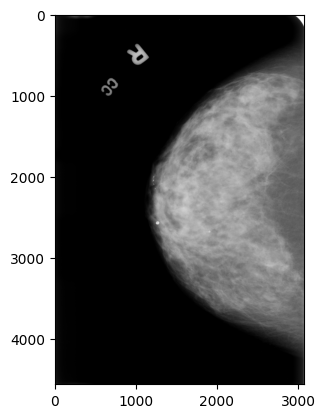

In [9]:
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in full_mammogram_images[0:5]:
  full_mammogram_images_show = PIL.Image.open(file)
  gray_img= full_mammogram_images_show.convert("L")
  plt.imshow(gray_img, cmap='gray')


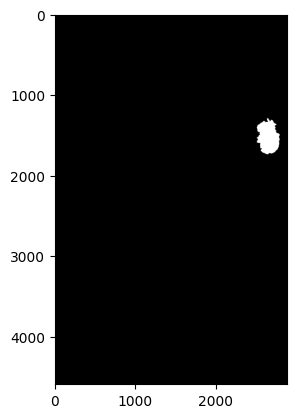

In [10]:
ROI_mask_images=dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in ROI_mask_images[0:5]:
    # Open the image using PIL (Python Imaging Library)
  ROI_mask_images_show = PIL.Image.open(file)
  gray_img= ROI_mask_images_show.convert("L")
  plt.imshow(gray_img, cmap='gray')

In [6]:
calc_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')

In [11]:
mass_case_df = pd.read_csv("input/csv/mass_case_description_train_set.csv")
# Read CSV files into DataFrames
mass_case_test_df=pd.read_csv('input/csv/mass_case_description_test_set.csv')

**Data cleaning**

In [12]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [13]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime',
                         'PatientSex','PatientBirthDate','ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                         'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'
                        ],axis =1, inplace=True) 

In [14]:
# Sütunda bulunan eksik değerleri bir sonraki değer ile dolduralım
dicom_cleaned_data['SeriesDescription'].ffill(inplace=True)
dicom_cleaned_data['Laterality'].bfill(inplace=True)
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [15]:
Data_cleaning_1 = calc_case_df.copy()
# Aşağıdaki satırlarda isim değişikliği yapılmıştır.
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'}) 
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})

# Belirtilen sütunlardaki veri tiplerini kategorik tipe dönüştürür.
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')

Data_cleaning_1.isna().sum()

NameError: name 'calc_case_df' is not defined

In [12]:
# Belirtilen sütunlar için tekrardan veri doldurma işlemi yapılır.
Data_cleaning_1['calc_type'].bfill(inplace=True)
Data_cleaning_1['calc_distribution'].bfill(inplace=True)
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [16]:
# Create a copy of 'data_2_test' DataFrame for cleaning
Data_cleaning_2_test = mass_case_test_df.copy()

# Rename columns in 'Data_cleaning_2_test' DataFrame
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'image view':'image_view'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'abnormality type':'abnormality_type'})
# Convert specified columns in 'Data_cleaning_2_test' to the 'category' data type
Data_cleaning_2_test['left_or_right_breast'] = Data_cleaning_2_test['left_or_right_breast'].astype('category')
Data_cleaning_2_test['image_view'] = Data_cleaning_2_test['image_view'].astype('category')
Data_cleaning_2_test['mass_margins'] = Data_cleaning_2_test['mass_margins'].astype('category')
Data_cleaning_2_test['mass_shape'] = Data_cleaning_2_test['mass_shape'].astype('category')
Data_cleaning_2_test['abnormality_type'] = Data_cleaning_2_test['abnormality_type'].astype('category')
Data_cleaning_2_test['pathology'] = Data_cleaning_2_test['pathology'].astype('category')
# Display the count of missing values in each column of 'Data_cleaning_2_test' DataFrame
Data_cleaning_2_test.isna().sum()
# Fill missing values in 'mass_margins' column of 'Data_cleaning_2_test' DataFrame using backward fill
Data_cleaning_2_test['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
# Display the count of missing values in each column of 'Data_cleaning_2' DataFrame
Data_cleaning_2_test.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [19]:
Data_cleaning_2 = mass_case_df.copy()
# isim değiştirme
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
#Veri tipini değiştirme
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [20]:
# Boş verileri dolduralım
Data_cleaning_2['mass_shape'].bfill(inplace=True) 
Data_cleaning_2['mass_margins'].bfill(inplace=True)  
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [21]:
# Create a DataFrame with counts of unique values in 'SeriesDescription' column
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
# Reset the index to have 'SeriesDescription' as a column
r= r.reset_index()
# Rename columns for clarity
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
# Display the DataFrame
r

,SeriesDescription,SeriesDescription_counts
0,cropped images,3843
1,ROI mask images,3362
2,full mammogram images,3032


In [22]:
# Print the original column names in Data_cleaning_2 DataFrame
print(Data_cleaning_2.columns)
print('\n')
# Rename selected columns in Data_cleaning_2 DataFrame for better clarity
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# Display the updated column names in Data_cleaning_2 DataFrame
 


Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




In [23]:
Data_cleaning_2["image_file_path"].unique().tolist()[1]

'Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm'

In [24]:
# Print the original column names in Data_cleaning_2_test DataFrame
print(Data_cleaning_2_test.columns)
print('\n')
# Rename selected columns in Data_cleaning_2_test DataFrame for better clarity
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# Display the updated column names in Data_cleaning_2_test DataFrame
Data_cleaning_2_test.columns

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')

In [28]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()
# Iterate through full_mammogram_images and create a dictionary with keys based on unique identifiers
for dicom in full_mammogram_images:
    key = dicom.split("/")[2]
    full_mammo_dict[key] = dicom
# Iterate through cropped_images and create a dictionary with keys based on unique identifiers
for dicom in cropped_images:
    key = dicom.split("/")[2]
    cropped_images_dict[key] = dicom
# Iterate through ROI_mask_images and create a dictionary with keys based on unique identifiers

for dicom in ROI_mask_images:
    key = dicom.split("/")[2]
    roi_img_dict[key] = dicom

# Display the keys of the first item in full_mammo_dict
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 'input/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [29]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        
# apply to datasets
fix_image_path(Data_cleaning_2)
fix_image_path(Data_cleaning_2_test)

Full Mammograms:



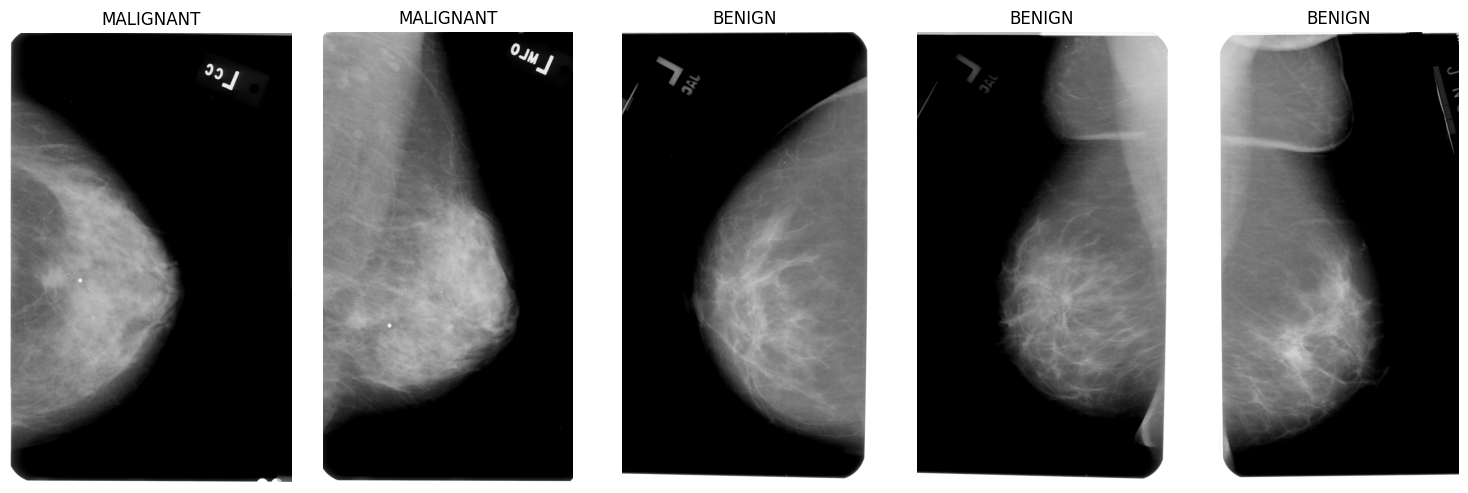

Cropped Mammograms:



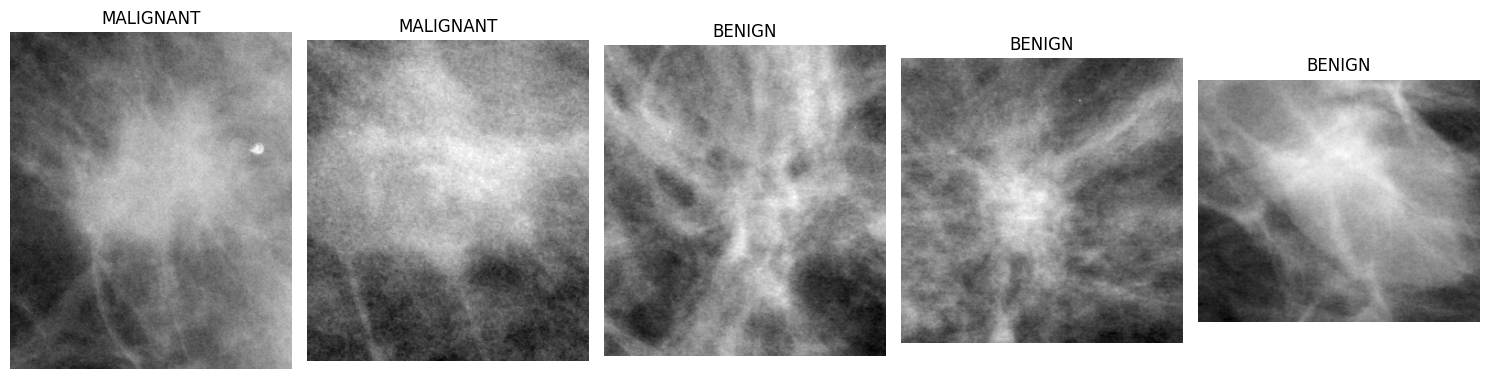

In [30]:
# create function to display images
def display_images(column, number):
    """displays images in the dataset"""
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in Data_cleaning_2.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        col_index = index % cols  # Calculate the correct column index
        ax = axes[col_index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)


In [22]:
def fix_image_path2(data):
    """Fixes image paths in the dataframe"""
    for index, img in enumerate(data.values):
        # Extract image name from the path
        img_name = img[11].split("/")[1]
        # Check if the image name is in the full_mammo_dict
        if img_name in full_mammo_dict:
            # Update the image path with the corresponding path from the full_mammo_dict
            data.iloc[index, 11] = full_mammo_dict[img_name]
        else:
            print(f"Key not found in full mammo dictionary: {img_name}")
            # Extract image name from the path
        
        img_name = img[12].split("/")[2]
        # Check if the image name is in the cropped_images_dict
        if img_name in cropped_images_dict:
            # Update the image path with the corresponding path from the cropped_images_dict
            data.iloc[index, 12] = cropped_images_dict[img_name]
        else:
            print(f"Key not found in cropped images dictionary: {img_name}")



# Mamografi Görüntülerinin İyileştirilmesi ve Bulanıklığının Giderilmesi: Kapsamlı Bir Yaklaşım


In [31]:
#Bu işlevin temel amacı, görüntüdeki kontrastı artırmak ve görsel kaliteyi iyileştirmektir, özellikle çok parlak veya çok karanlık alanlarda detayları artırmak için kullanılır.
def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    # Convert the image to LAB color space,  LAB renk uzayı, parlaklık (L), a (yeşil-kırmızı eksen) ve b (mavi-sarı eksen)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE on the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    clahe_l = clahe.apply(l)

    # Merge the CLAHE enhanced L channel with the original A and B channels
    clahe_lab = cv2.merge((clahe_l, a, b))

    # Convert the LAB image back to BGR color space
    clahe_bgr = cv2.cvtColor(clahe_lab, cv2.COLOR_LAB2BGR)

    return clahe_bgr

In [32]:
#Bu Python fonksiyonu, bir hazy (sisli) görüntüdeki sis etkisini azaltan bir hava temizleme işlemi gerçekleştirir.
def haze_reduced_local_global(hazy_image, window_size=15, epsilon=0.001):
    # Convert the hazy image to LAB color space
    hazy_lab = cv2.cvtColor(hazy_image, cv2.COLOR_BGR2LAB)
    hazy_l, hazy_a, hazy_b = cv2.split(hazy_lab)

    # Estimate the atmospheric light
    atmospheric_light = np.max(hazy_l)

    # Calculate the dark channel of the hazy image
    hazy_dark = cv2.erode(hazy_l, cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size)))

    # Estimate the transmission map
    transmission_map = 1 - hazy_dark / atmospheric_light

    # Calculate the refined transmission map
    refined_transmission_map = cv2.max(transmission_map, epsilon)

    # Calculate the inverse transmission map
    inverse_transmission_map = 1 / refined_transmission_map

    # Dehaze the image
    dehazed_l = (hazy_l.astype(np.float32) - atmospheric_light) * inverse_transmission_map + atmospheric_light

    # Clip the dehazed L channel to the valid range [0, 255]
    dehazed_l = np.clip(dehazed_l, 0, 255).astype(np.uint8)

    # Merge the dehazed L channel with the original A and B channels
    dehazed_lab = cv2.merge((dehazed_l, hazy_a, hazy_b))

    # Convert the LAB image back to BGR color space
    dehazed_bgr = cv2.cvtColor(dehazed_lab, cv2.COLOR_LAB2BGR)

    return dehazed_bgr

In [33]:
#Bu Python fonksiyonu, Convolutional Analysis Operator Learning (CAOL) çerçevesini kullanarak bir gri tonlu görüntünün özellikle düşük seviyeli öznitelikleri çıkarmak için bir sparse coding işlemi gerçekleştirir. 
def csid_caol(image_path, n_components, patch_size, iterations):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Extract patches from the image
    patches = cv2.extract_patches_2d(image, (patch_size, patch_size))

    # Reshape the patches for sparse coding
    patches = patches.reshape(patches.shape[0], -1)

    # Perform sparse coding using the Convolutional Analysis Operator Learning (CAOL) framework
    coder = SparseCoder(dictionary=np.random.randn(patch_size * patch_size, n_components), transform_algorithm='lasso_lars')
    codes = coder.transform(patches.T)

    # Reconstruct the image using the learned codes
    reconstructed_patches = np.dot(codes.T, coder.components_).reshape(-1, patch_size, patch_size)
    reconstructed_image = cv2.reconstruct_patches_2d(reconstructed_patches, (image.shape[0], image.shape[1]))

    return reconstructed_image.astype(np.uint8)

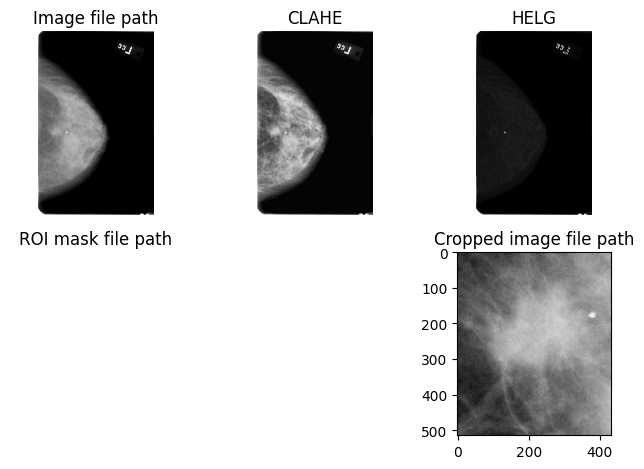

In [34]:
img_full = mpimg.imread(Data_cleaning_2.iloc[0]['image_file_path'])
img_full_cv2 = cv2.imread(Data_cleaning_2.iloc[0]['image_file_path'], cv2.IMREAD_COLOR)
img_full_clahe = apply_clahe(img_full_cv2)
img_full_helg = haze_reduced_local_global(img_full_cv2)

img_crop = mpimg.imread(Data_cleaning_2.iloc[0]['cropped_image_file_path'])
#img_roi = mpimg.imread(mass_data.iloc[0]['ROI_mask_file_path'])
    

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(img_full, cmap='gray')
axs[0,1].imshow(img_full_clahe, cmap='gray')
axs[0,2].imshow(img_full_helg, cmap='gray')
#axs[1,0].imshow(img_roi, cmap='gray')
axs[1,2].imshow(img_crop, cmap='gray')

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')

axs[0,0].set_title('Image file path')
axs[0,1].set_title('CLAHE')
axs[0,2].set_title('HELG')
axs[1,0].set_title('ROI mask file path')
axs[1,2].set_title('Cropped image file path')

plt.tight_layout()

plt.show()

# Data Preprocessing

In [35]:
tf.random.set_seed(100)

# Define a classification dictionary for pathology
classification = {"MALIGNANT": 0, "BENIGN_WITHOUT_CALLBACK": 1, "BENIGN": 1}

In [36]:
def load_image(img):
    # Load and resize the image
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (224, 224), interpolation = cv2.INTER_LINEAR)
    return c_img_size

def get_pathology(pathology):
    # Sınıflandırma sözlüğünü kullanarak patolojiyi sayısal değerlerle eşleme
    return classification[pathology]

def get_images_result(dataset):
    # Paralel görüntü yükleme için ThreadPoolExecutor'u kullanın
    with ThreadPoolExecutor() as executor: 
        # Load images and get pathology results using parallel processing
        images = np.array(list(executor.map(load_image, dataset.loc[:]['image_file_path'])))
        result = np.array(list(executor.map(get_pathology, dataset.loc[:]['pathology'])))
    # Convert pathology results to categorical format
    result = to_categorical(result)
    return (images, result)

In [37]:
# Eğitim ve test veri kümelerini karıştırın
mass_train_data_shuffled = Data_cleaning_2.sample(frac = 1)
mass_test_data_shuffled = Data_cleaning_2_test.sample(frac = 1)
# MResimleri yüklemek ve yeniden boyutlandırmak için geçen süreyi ölçün
tic = time.perf_counter()
(X_train, y_train) = get_images_result(mass_train_data_shuffled)
(X_test, y_test) = get_images_result(mass_test_data_shuffled)
toc = time.perf_counter()
print(f"Uploading the images and resizing in {toc - tic:0.4f} seconds")
# Eğitim ve test veri kümelerinin şekillerini görüntüle
print('X_train shape : {}' .format(X_train.shape))
print('y_train shape : {}' .format(y_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_test shape : {}' .format(y_test.shape))

Uploading the images and resizing in 23.8091 seconds
X_train shape : (1318, 224, 224, 3)
y_train shape : (1318, 2)
X_test shape : (378, 224, 224, 3)
y_test shape : (378, 2)


## CNN-cbis ddsm breast cancer dataset

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_cnn_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Increase the number of neurons in the dense layer
    model.add(Dropout(0.2))  # Adjust dropout rate
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(2, activation='softmax'))  
    
    # Compile the model with a lower learning rate
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    return model, early_stopping

cnn_model, early_stopping = create_cnn_model(input_shape=(224, 224, 3))
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks=early_stopping)


# Print the final accuracy and loss
final_loss, final_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Final Validation Loss: {final_loss:.4f}')
print(f'Final Validation Accuracy: {final_accuracy:.4f}')


2024-07-27 00:26:12.799095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 00:26:12.831098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 00:26:12.831296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/30


2024-07-27 00:26:14.259383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-07-27 00:26:16.236703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-07-27 00:26:16.780623: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-27 00:26:16.780666: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_10' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_47801/551224325.py", line 47, in <module>
      history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks=early_stopping)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/nextory/PycharmProjects/venv/nx-reco-engine/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_10'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_10}}]] [Op:__inference_train_function_1635]

In [31]:
# Save the trained model to a file
cnn_model.save("cnn_model.h5")
print("Model saved to disk.")

# Load the model back (optional)
loaded_model = load_model("cnn_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


## DenseNet121-cbis ddsm breast cancer dataset

In [32]:
from tensorflow.keras.applications import DenseNet121

def create_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    return model, early_stopping

# Reshape the input data
input_shape_densenet = (224, 224, 3)

# Create and compile the modified DenseNet121 model
densenet_model, early_stopping_densenet = create_densenet_model(input_shape_densenet)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model
history_densenet = densenet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping_densenet])

# Evaluate the model
final_loss_densenet, final_accuracy_densenet = densenet_model.evaluate(X_test, y_test)
print(f'Final Validation Loss (DenseNet): {final_loss_densenet:.4f}')
print(f'Final Validation Accuracy (DenseNet): {final_accuracy_densenet:.4f}')

# Save the DenseNet model to an h5 file
densenet_model.save('denseNet_model_cbis.h5')
print("DenseNet121 Model saved to disk.")

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/30
42/42 [==============================] - 94s 556ms/step - loss: 6.2036 - accuracy: 0.4932 - val_loss: 1237555.8750 - val_accuracy: 0.6111
Epoch 2/30
42/42 [==============================] - 16s 372ms/step - loss: 2.2723 - accuracy: 0.5015 - val_loss: 25993.0234 - val_accuracy: 0.3889
Epoch 3/30
42/42 [==============================] - 15s 360ms/step - loss: 0.9163 - accuracy: 0.5273 - val_loss: 1.8604 - val_accuracy: 0.5952
Epoch 4/30
42/42 [==============================] - 16s 377ms/step - loss: 0.7042 - accuracy: 0.5197 - val_loss: 0.7320 - val_accuracy: 0.5979
Epoch 5/30
42/42 [==============================] - 16s 372ms/step - loss: 0.6913 - accuracy: 0.5205 - val_loss: 0.6895 - val_accuracy: 0.6085
Epoch 6/30
42/42 [==============================] - 16s 373ms/step - loss: 0.7064 - accuracy: 0.5175 - val_loss: 0.6867 - val_accuracy: 0.6111
Epoch 7/30
42/42 [==============================] - 16s 366ms/step 

# EfficientNetB0 Cbis

In [33]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the modified model with EfficientNetB0 base
def create_efficientnet_model(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    model = Sequential()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    return model, early_stopping

# Reshape the input data
input_shape_efficientnet = (224, 224, 3)

# Create and compile the modified EfficientNetB0 model
efficientnet_model, early_stopping_efficientnet = create_efficientnet_model(input_shape_efficientnet)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model
history_efficientnet = efficientnet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping_efficientnet])

# Evaluate the model
final_loss_efficientnet, final_accuracy_efficientnet = efficientnet_model.evaluate(X_test, y_test)
print(f'Final Validation Loss (EfficientNetB0): {final_loss_efficientnet:.4f}')
print(f'Final Validation Accuracy (EfficientNetB0): {final_accuracy_efficientnet:.4f}')

# Save the modified EfficientNetB0 model to an h5 file
efficientnet_model.save('efficientnetb0_model_cbis.h5')
print("Modified EfficientNetB0 Model saved to disk.")


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/30


2024-01-27 16:24:42.130753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 59s 430ms/step - loss: 0.7141 - accuracy: 0.5349 - val_loss: 0.6653 - val_accuracy: 0.6270
Epoch 2/30
42/42 [==============================] - 15s 354ms/step - loss: 0.6586 - accuracy: 0.6138 - val_loss: 0.6790 - val_accuracy: 0.5714
Epoch 3/30
42/42 [==============================] - 15s 348ms/step - loss: 0.6530 - accuracy: 0.6146 - val_loss: 0.6294 - val_accuracy: 0.6852
Epoch 4/30
42/42 [==============================] - 15s 354ms/step - loss: 0.6433 - accuracy: 0.6335 - val_loss: 0.6218 - val_accuracy: 0.6958
Epoch 5/30
42/42 [==============================] - 15s 356ms/step - loss: 0.6359 - accuracy: 0.6472 - val_loss: 0.6776 - val_accuracy: 0.5291
Epoch 6/30
42/42 [==============================] - 15s 352ms/step - loss: 0.6402 - accuracy: 0.6351 - val_loss: 0.7324 - val_accuracy: 0.4815
Epoch 7/30
42/42 [==============================] - 15s 345ms/step - loss: 0.6183 - accuracy: 0.6593 - val_loss: 0.9692 - val_accuracy: 0.5106
Epoch 8/30

# İkinci veri setinin eklenmesi


In [34]:
base_directory = '../input/breast-histopathology-images/IDC_regular_ps50_idx5/'

# Dosya yollarını tutacak boş bir liste oluşturun
breast_img = []

# Ana dizindeki tüm alt dizinleri alın
subdirectories = [f.path for f in os.scandir(base_directory) if f.is_dir()]

# Her alt dizinde dolaşın ve dosya yollarını ekleyin
for subdirectory in subdirectories:
    for root, dirs, files in os.walk(subdirectory):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                breast_img.append(file_path)

# İlk birkaç dosyayı gösterin
for imgname in breast_img[:3]:
    print(imgname)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [35]:
non_can_img = []   #non-cancerous (kansersiz) listesi
can_img = []       #cancerous (kanserli) listesi
#son karaktere bakılarak 0 ise kansersiz 1 ise kanserli listesine ekle
for img in breast_img:
    if img[-5] == '0' :
        non_can_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)
        
        
non_can_num = len(non_can_img)  # No cancer
can_num = len(can_img)          # Cancer 
        
total_img_num = non_can_num + can_num
        
print('Number of Images of no cancer: {}' .format(non_can_num))   
print('Number of Images of cancer : {}' .format(can_num))          
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [36]:
#listelerinden rastgele örnekler alır 
max_samples = 20000                                                             # zamandan tasrruf için örnek sayısını sınırladık
some_non_img = random.sample(non_can_img, min(len(non_can_img), max_samples))  #kansersiz görüntülerin dosya yolu
some_can_img = random.sample(can_img, min(len(can_img), max_samples))          #kanserli görüntülerin dosya yolu

non_img_arr = []
can_img_arr = []

#Her iki kategoriye ait görüntüleri küçültür ve renkli görüntüleri siyah-beyaz formatına dönüştürür. 
#Her bir görüntüyü (50x50 piksel boyutunda) içeren bir liste oluşturur ve bu listeye etiketi (0 veya 1) ekler.
for img in some_non_img: #kansersiz görüntülerin işlenmesi başlar.
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)                                  #OpenCV kullanılarak resim dosyası okunur.
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR) #Okunan resim, 50x50 piksel boyutuna küçültülür
    non_img_arr.append([n_img_size, 0])                                        #Küçültülen resim, etiketi (0) ile birlikte non_img_arr listesine eklenir.
    confusion_matrix
for img in some_can_img: #kanserli görüntülerin işlenmesi başlar.
    
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])
    
# Listeler birleştirelim
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr) #Birleştirilen liste karıştırılır.Bu, öğrenme algoritmalarına eğitim verilerini daha iyi sunmak için önemlidir.



In [37]:
X = []
y = []

#özellik ve etiket için listeden örnek döndürelim.
for feature, label in breast_img_arr: 
    X.append(feature)
    y.append(label)

#  NumPy dizilerine dönüştürelim.
X = np.array(X)
y = np.array(y)

#verinin %20'sinin test setine ayrılsın.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Bir azaltma (downsampling) oranı belirlenir. num değişkeni, oran ile çarpılarak eğitim verisinin boyutunu belirler.
rate = 0.5
num = int(X.shape[0] * rate)

#Etiketler one-hot encoding'e dönüştür
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (32000, 50, 50, 3)
X_test shape : (8000, 50, 50, 3)
y_train shape : (32000, 2)
y_test shape : (8000, 2)


## CNN-breast histopathology dataset

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Veriyi artırma için ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Yeni modeli oluşturun
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

# Modeli derleme
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Erken durdurma için geri çağırma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Veri artırma ve modeli eğitme
history_cnn = model_cnn.fit(datagen.flow(X_train, y_train, batch_size=75),
                            validation_data=(X_test, y_test),
                            epochs=25,
                            callbacks=[early_stopping])

# Modeli değerlendirme
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_cnn}, Test Accuracy: {test_accuracy_cnn}')

# Modeli kaydetme
model_cnn.save('model_breastHistoryDataset_Cnn.h5')
print("CNN model saved to disk.")

# Modeli yükleyerek tahmin yapma
loaded_model_cnn = tf.keras.models.load_model('model_breastHistoryDataset_Cnn.h5')
predictions_cnn = loaded_model_cnn.predict(X_test)


Epoch 1/25
427/427 [==============================] - 31s 68ms/step - loss: 0.8250 - accuracy: 0.7362 - val_loss: 0.5172 - val_accuracy: 0.7801
Epoch 2/25
427/427 [==============================] - 29s 67ms/step - loss: 0.4885 - accuracy: 0.7786 - val_loss: 0.4902 - val_accuracy: 0.7679
Epoch 3/25
427/427 [==============================] - 29s 67ms/step - loss: 0.4752 - accuracy: 0.7849 - val_loss: 0.4747 - val_accuracy: 0.7905
Epoch 4/25
427/427 [==============================] - 29s 67ms/step - loss: 0.4657 - accuracy: 0.7888 - val_loss: 0.4246 - val_accuracy: 0.8094
Epoch 5/25
427/427 [==============================] - 29s 67ms/step - loss: 0.4659 - accuracy: 0.7933 - val_loss: 0.4544 - val_accuracy: 0.7968
Epoch 6/25
427/427 [==============================] - 29s 68ms/step - loss: 0.4484 - accuracy: 0.8008 - val_loss: 0.4973 - val_accuracy: 0.7732
Epoch 7/25
427/427 [==============================] - 29s 68ms/step - loss: 0.4378 - accuracy: 0.8112 - val_loss: 0.4212 - val_accuracy:

## EfficientNetB0 - breast histopathology dataset

In [39]:
# Veriyi artırma için ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(50, 50, 3))
base_model.trainable = False  # Transfer learning için önceden eğitilmiş ağırlıkları dondurun

# Yeni modeli oluşturun
model_efficientnetb0 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Modeli derleme
model_efficientnetb0.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Erken durdurma için geri çağırma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Veri artırma ve modeli eğitme
history_efficientnetb0 = model_efficientnetb0.fit(datagen.flow(X_train, y_train, batch_size=75),
                                                  validation_data=(X_test, y_test),
                                                  epochs=25,
                                                  callbacks=[early_stopping])

# Modeli değerlendirme
test_loss_efficientnetb0, test_accuracy_efficientnetb0 = model_efficientnetb0.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_efficientnetb0}, Test Accuracy: {test_accuracy_efficientnetb0}')

# Modeli kaydetme
model_efficientnetb0.save('model_breastHistoryDataset_efficientnetb0.h5')
print("EfficientNetB0 model saved to disk.")

# Modeli yükleyerek tahmin yapma
loaded_model_efficientnetb0 = tf.keras.models.load_model('model_breastHistoryDataset_efficientnetb0.h5')
predictions_efficientnetb0 = loaded_model_efficientnetb0.predict(X_test)


Epoch 1/25


2024-01-27 16:50:52.465882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


427/427 [==============================] - 41s 79ms/step - loss: 0.5051 - accuracy: 0.7591 - val_loss: 0.4741 - val_accuracy: 0.7715
Epoch 2/25
427/427 [==============================] - 31s 74ms/step - loss: 0.4740 - accuracy: 0.7778 - val_loss: 0.4402 - val_accuracy: 0.8033
Epoch 3/25
427/427 [==============================] - 33s 78ms/step - loss: 0.4636 - accuracy: 0.7859 - val_loss: 0.4421 - val_accuracy: 0.7956
Epoch 4/25
427/427 [==============================] - 34s 79ms/step - loss: 0.4589 - accuracy: 0.7866 - val_loss: 0.4480 - val_accuracy: 0.7881
Epoch 5/25
427/427 [==============================] - 32s 75ms/step - loss: 0.4544 - accuracy: 0.7919 - val_loss: 0.4368 - val_accuracy: 0.7989
Epoch 6/25
427/427 [==============================] - 32s 75ms/step - loss: 0.4513 - accuracy: 0.7886 - val_loss: 0.4313 - val_accuracy: 0.8073
Epoch 7/25
427/427 [==============================] - 32s 74ms/step - loss: 0.4493 - accuracy: 0.7925 - val_loss: 0.4360 - val_accuracy: 0.7980
Epo

## DenseNet121 - breast histopathology dataset

In [40]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

# Veriyi artırma için ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(50, 50, 3))
base_model.trainable = False  # Transfer learning için önceden eğitilmiş ağırlıkları dondurun

# Yeni modeli oluşturun
model_densenet121 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Modeli derleme
model_densenet121.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Erken durdurma için geri çağırma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Veri artırma ve modeli eğitme
history_densenet121 = model_densenet121.fit(datagen.flow(X_train, y_train, batch_size=75),
                                            validation_data=(X_test, y_test),
                                            epochs=25,
                                            callbacks=[early_stopping])

# Modeli değerlendirme
test_loss_densenet121, test_accuracy_densenet121 = model_densenet121.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_densenet121}, Test Accuracy: {test_accuracy_densenet121}')

# Modeli kaydetme
model_densenet121.save('model_breastHistoryDataset_densenet121.h5')
print("DenseNet121 model saved to disk.")

# Modeli yükleyerek tahmin yapma
loaded_model_densenet121 = tf.keras.models.load_model('model_breastHistoryDataset_densenet121.h5')
predictions_densenet121 = loaded_model_densenet121.predict(X_test)


Epoch 1/25
427/427 [==============================] - 47s 90ms/step - loss: 0.5723 - accuracy: 0.7483 - val_loss: 0.5867 - val_accuracy: 0.7124
Epoch 2/25
427/427 [==============================] - 34s 79ms/step - loss: 0.4898 - accuracy: 0.7745 - val_loss: 0.5658 - val_accuracy: 0.7362
Epoch 3/25
427/427 [==============================] - 34s 80ms/step - loss: 0.4758 - accuracy: 0.7845 - val_loss: 0.6852 - val_accuracy: 0.6674
Epoch 4/25
427/427 [==============================] - 34s 80ms/step - loss: 0.4736 - accuracy: 0.7856 - val_loss: 0.5602 - val_accuracy: 0.7429
Epoch 5/25
427/427 [==============================] - 35s 81ms/step - loss: 0.4657 - accuracy: 0.7871 - val_loss: 0.5127 - val_accuracy: 0.7659
Epoch 6/25
427/427 [==============================] - 33s 78ms/step - loss: 0.4653 - accuracy: 0.7907 - val_loss: 0.5560 - val_accuracy: 0.7504
Epoch 7/25
427/427 [==============================] - 34s 80ms/step - loss: 0.4701 - accuracy: 0.7870 - val_loss: 0.5471 - val_accuracy:

# Karışıklık matrisi (confusion matrix)
Şimdi de model_breastHistoryDataset_cnnin test verisi üzerindeki tahminlerini kullanarak bir karışıklık matrisi (confusion matrix) oluşturalım. Bu matrisi de ısı haritası şeklinde görselleştirelim.

250/250 [==============================] - 1s 2ms/step


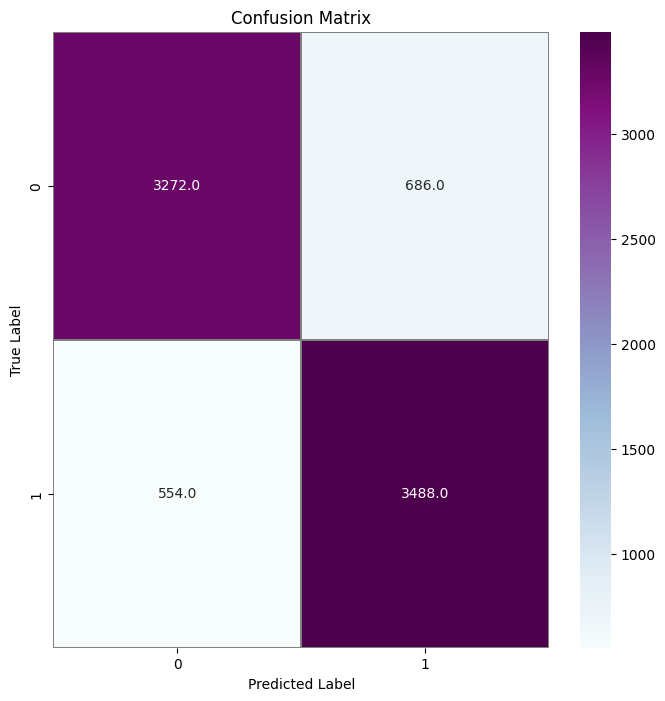

In [41]:
Y_pred = model_cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

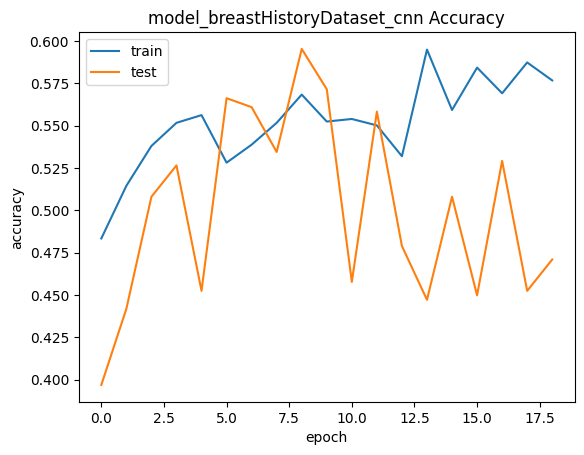

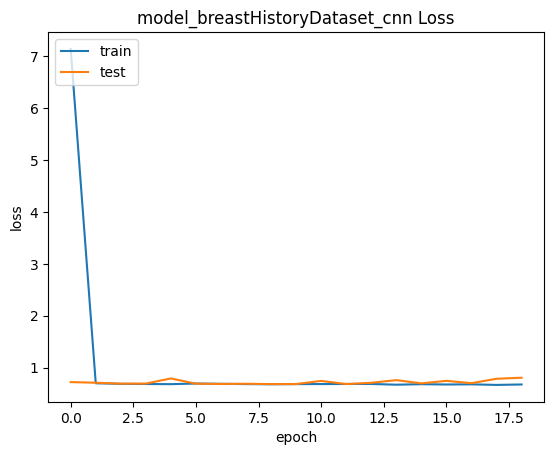

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_breastHistoryDataset_cnn Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_breastHistoryDataset_cnn Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

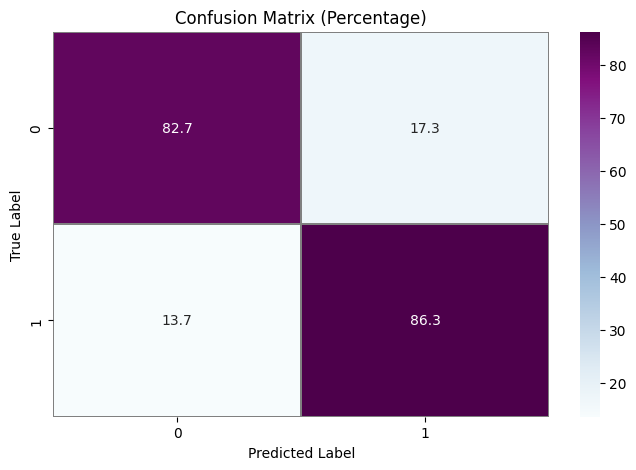

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model_breastHistoryDataset_cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(y_test, axis=1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Testing the Model

1/1 [==============================] - 0s 266ms/step
Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


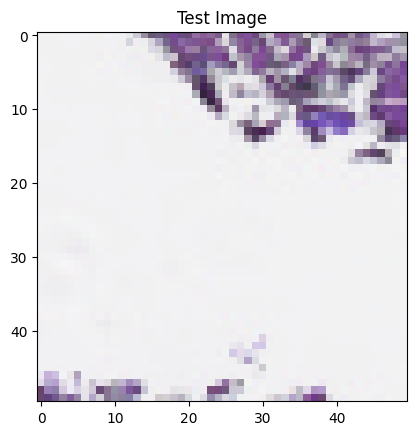

In [44]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

# Define a function for plotting an image from an array
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')
    
    # Display the image at the specified index in the array
    plt.imshow(arr[index])

# Set the index value to 90
index = 90

# Plot an image from the X_test array using the img_plot function
img_plot(X_test, index)

# Extract a single image from X_test based on the specified index
input = X_test[index:index+1]

# Make a prediction using the CNN model and get the class with the highest probability
predicted_class_index = loaded_model_cnn.predict(input)[0].argmax()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)